# Week 4 - Survival Analysis

Survival analysis is a branch of statistics for analyzing the expected duration of time until an event occurs, such as death in biological organisms or failure in mechanical systems. This topic is also called reliability theory or reliability analysis in engineering, duration analysis or duration modelling in economics, and event history analysis in sociology. Survival analysis attempts to answer certain questions, such as what is the proportion of a population which will survive past a certain time? Of those that survive, at what rate will they die or fail? Can multiple causes of death or failure be taken into account? How do particular circumstances or characteristics increase or decrease the probability of survival?

https://en.wikipedia.org/wiki/Survival_analysis

In [1]:
# pip install lifelines

# Readings

* https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
* https://towardsdatascience.com/hands-on-survival-analysis-with-python-270fa1e6fb41
* https://github.com/Idilismiguzel/Machine-Learning/blob/master/Survival_Analysis/Survival_Analysis.ipynb
* https://www.kdnuggets.com/2020/07/complete-guide-survival-analysis-python-part1.html
* https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d
* https://stat.ethz.ch/R-manual/R-devel/library/survival/html/lung.html

# Key Concepts

* Time to Event: Relapse, Improvement, Death
* Stratified sampling to deal with volume of data (equal or near equal amount of subjects from groups)
* Survival Curves
* Kaplan Meier Estimator
* Censoring
* Log Rank Test

# Uses

* Cancer Studies
* Event History Analysis
* Failure Analysis - when will a battery fail
* Traffic - What happens after the light turns red
* Churn and Attrition
* Retention Rate
* Processes Reaching Critical Values
* Time From Sale Contact to Sale
* Warranty Claims 

In [2]:
# make the dataframe
import pandas as pd

lung = pd.read_csv('lung.csv')
lung.head()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


# Info

* status: dead or alive
* time: length of observation
* inst: number in bucket

for example 3 reached event 2 within 306 units of time

In [3]:
# check nulls and data types
lung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


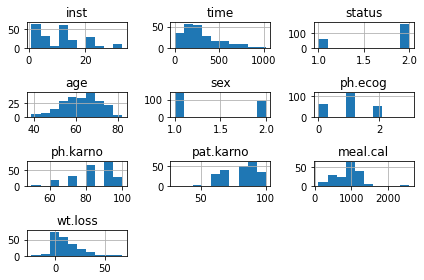

In [4]:
# checkout shapes 
import matplotlib.pyplot as plt

lung.hist()
plt.tight_layout();

In [5]:
# what's the index of a missing value? 
lung[lung['inst'].isnull()].index.tolist()

[155]

In [6]:
# the values of observation 155
lung.loc[155]

inst           NaN
time         329.0
status         2.0
age           69.0
sex            1.0
ph.ecog        2.0
ph.karno      70.0
pat.karno     80.0
meal.cal     713.0
wt.loss       20.0
Name: 155, dtype: float64

In [7]:
# compare missing observation with other like data
lung[(lung['sex'] == 1) & (lung['status'] == 2) & (lung['time'] > 300) & (lung['time'] < 400)]

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
20,11.0,301,2,67,1,1.0,80.0,80.0,1025.0,17.0
23,15.0,371,2,58,1,0.0,90.0,100.0,975.0,13.0
24,12.0,394,2,72,1,0.0,90.0,80.0,NaN,0.0
28,13.0,390,2,53,1,1.0,80.0,70.0,875.0,-7.0
46,1.0,303,2,74,1,0.0,90.0,70.0,463.0,30.0
97,12.0,310,2,71,1,1.0,90.0,100.0,NaN,0.0
102,13.0,364,2,56,1,1.0,70.0,80.0,NaN,4.0
119,15.0,363,2,80,1,1.0,80.0,90.0,346.0,11.0
132,6.0,353,2,47,1,0.0,100.0,90.0,1225.0,5.0


In [8]:
# get descriptive stats for inst
lung[(lung['sex'] == 1) & (lung['status'] == 2) & (lung['time'] > 300) & (lung['time'] < 400)].describe()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,14.000000,15.000000,15.0,15.000000,15.0,15.000000,15.000000,15.000000,12.000000,13.000000
mean,11.142857,345.400000,2.0,63.333333,1.0,0.666667,87.333333,85.333333,917.250000,8.769231
std,5.517206,32.806358,0.0,10.714921,0.0,0.723747,10.327956,13.020131,321.962484,10.059439
min,1.000000,301.000000,2.0,46.000000,1.0,0.000000,70.000000,60.000000,346.000000,-7.000000
25%,7.250000,315.000000,2.0,56.000000,1.0,0.000000,80.000000,80.000000,759.500000,2.000000
50%,12.500000,353.000000,2.0,67.000000,1.0,1.000000,90.000000,80.000000,925.000000,5.000000
75%,14.500000,367.500000,2.0,71.500000,1.0,1.000000,95.000000,100.000000,1100.000000,15.000000
max,21.000000,394.000000,2.0,80.000000,1.0,2.000000,100.000000,100.000000,1500.000000,30.000000


In [9]:
int(lung['inst'].where((lung['sex'] == 1) & (lung['status'] == 2) & (lung['time'] > 300) & (lung['time'] < 400)).mean())

11

In [10]:
# replace missing value with mean
lung['inst'].fillna(int(lung['inst'].where((lung['sex'] == 1) & (lung['status'] == 2) & (lung['time'] > 300) & (lung['time'] < 400)).mean()), inplace=True)
lung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       228 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


In [11]:
# get index of ph.ecog missing value
lung[lung['ph.ecog'].isnull()].index.tolist()

[13]

In [12]:
# get info
lung.loc[13]

inst           21.0
time           71.0
status          2.0
age            60.0
sex             1.0
ph.ecog         NaN
ph.karno       60.0
pat.karno      70.0
meal.cal     1225.0
wt.loss        32.0
Name: 13, dtype: float64

In [13]:
lung[(lung['sex'] == 1) & (lung['status'] == 2) & (lung['age'] == 60)]

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0
13,21.0,71,2,60,1,NaN,60.0,70.0,1225.0,32.0
26,4.0,574,2,60,1,0.0,100.0,100.0,1025.0,-13.0
199,32.0,135,2,60,1,1.0,90.0,70.0,1275.0,0.0


In [14]:
lung['ph.ecog'].fillna(1.0, inplace=True)
lung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       228 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    228 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


In [15]:
# get index of ph.karno missing value
lung[lung['ph.karno'].isnull()].index.tolist()

[205]

In [16]:
# get info
lung.loc[205]

inst          33.0
time         105.0
status         2.0
age           62.0
sex            1.0
ph.ecog        2.0
ph.karno       NaN
pat.karno     70.0
meal.cal       NaN
wt.loss        NaN
Name: 205, dtype: float64

In [17]:
lung[(lung['sex'] == 1) & (lung['status'] == 2) & (lung['ph.ecog'] == 2.0) & (lung['pat.karno'] == 70)]

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
9,7.0,166,2,61,1,2.0,70.0,70.0,271.0,34.0
17,16.0,707,2,63,1,2.0,50.0,70.0,1025.0,22.0
31,1.0,26,2,73,1,2.0,60.0,70.0,388.0,20.0
89,1.0,163,2,72,1,2.0,70.0,70.0,910.0,2.0
115,1.0,13,2,76,1,2.0,70.0,70.0,413.0,20.0
117,1.0,524,2,68,1,2.0,60.0,70.0,1300.0,30.0
142,26.0,222,2,76,1,2.0,70.0,70.0,1500.0,8.0
191,16.0,81,2,52,1,2.0,60.0,70.0,1075.0,NaN
205,33.0,105,2,62,1,2.0,NaN,70.0,NaN,NaN


In [18]:
lung[(lung['sex'] == 1) & (lung['status'] == 2) & (lung['ph.ecog'] == 2.0) & (lung['pat.karno'] == 70)].describe()

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,9.000000,9.000000,9.0,9.000000,9.0,9.0,8.000000,9.0,8.000000,7.000000
mean,11.333333,223.000000,2.0,67.000000,1.0,2.0,63.750000,70.0,860.250000,19.428571
std,12.114041,236.829052,0.0,8.108637,0.0,0.0,7.440238,0.0,454.919695,11.296860
min,1.000000,13.000000,2.0,52.000000,1.0,2.0,50.000000,70.0,271.000000,2.000000
25%,1.000000,81.000000,2.0,62.000000,1.0,2.0,60.000000,70.0,406.750000,14.000000
50%,7.000000,163.000000,2.0,68.000000,1.0,2.0,65.000000,70.0,967.500000,20.000000
75%,16.000000,222.000000,2.0,73.000000,1.0,2.0,70.000000,70.0,1131.250000,26.000000
max,33.000000,707.000000,2.0,76.000000,1.0,2.0,70.000000,70.0,1500.000000,34.000000


In [19]:
lung['ph.karno'].fillna(60.0, inplace=True)
lung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       228 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    228 non-null    float64
 6   ph.karno   228 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


In [20]:
# get index of ph.karno missing value
lung[lung['pat.karno'].isnull()].index.tolist()

[66, 78, 104]

In [21]:
# get info
lung.loc[[66, 78, 104]]

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
66,16.0,208,2,67,2,2.0,70.0,NaN,538.0,2.0
78,3.0,11,2,81,1,0.0,90.0,NaN,731.0,15.0
104,13.0,177,2,59,1,2.0,50.0,NaN,NaN,32.0


In [22]:
# lung.grouby('pat.karno')['sex'].mean()
lung.groupby(['pat.karno', 'sex'])['ph.karno'].mean()

pat.karno  sex
30.0       1      70.000000
           2      70.000000
40.0       1      50.000000
           2      60.000000
50.0       1      70.000000
           2      55.000000
60.0       1      75.555556
           2      70.833333
70.0       1      75.000000
           2      78.181818
80.0       1      82.812500
           2      85.789474
90.0       1      89.032258
           2      86.551724
100.0      1      88.095238
           2      87.857143
Name: ph.karno, dtype: float64

In [23]:
lung.loc[104,'pat.karno'] = 70
lung.loc[66,'pat.karno'] = 80
lung.loc[78,'pat.karno'] = 90
lung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       228 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    228 non-null    float64
 6   ph.karno   228 non-null    float64
 7   pat.karno  228 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


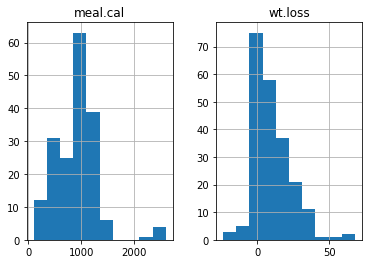

In [24]:
lung[['meal.cal', 'wt.loss']].hist();

In [25]:
lung['meal.cal'].fillna(lung['meal.cal'].mode()[0], inplace=True)
lung['wt.loss'].fillna(lung['wt.loss'].median(), inplace=True)
lung.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       228 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    228 non-null    float64
 6   ph.karno   228 non-null    float64
 7   pat.karno  228 non-null    float64
 8   meal.cal   228 non-null    float64
 9   wt.loss    228 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB


# Kaplan Meier Estimator

The Kaplan–Meier estimator, also known as the product limit estimator, is a non-parametric statistic used to estimate the survival function from lifetime data.

https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

Kaplan-Meier is the most commonly used life-table method in medical practice. It adequately copes with the issues such as, such as patients for whom the event has not yet occurred and for those lost to follow up. The data required by the method include the time of commencement of the treatment and the time the measured event occurred (e.g., death, relapse, or hospitalization). Patients who dropped out from treatment and those who are still alive at the end of the study period are “censored”, but the contribution that they have made to the event probability are fully accounted for.

https://advancedrenaleducation.com/wparep/article/life-table-survival-analysis/

In [26]:
# train the estimator
from lifelines import KaplanMeierFitter

model = KaplanMeierFitter()
model.fit(durations = lung.time, event_observed = lung.status)
model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,1,0,0,5
883.0,1,1,0,0,4
965.0,1,1,0,0,3


# Survival Curves

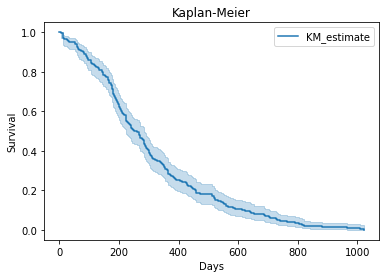

In [27]:
# survival curve
import matplotlib.pyplot as plt

model.plot()
plt.title("Kaplan-Meier")
plt.xlabel("Days")
plt.ylabel("Survival");

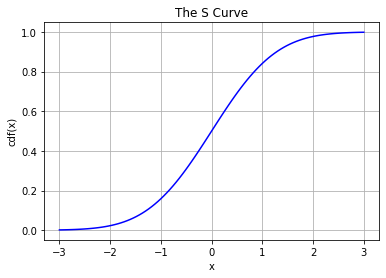

In [28]:
# the S curve; https://smallbusiness.chron.com/s-curve-business-23032.html
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

x = np.linspace(-3, 3, 100)
y = stats.norm.cdf(x)
plt.plot(x, y, 'b', label='cdf')
plt.title('The S Curve')
plt.xlabel('x') 
plt.ylabel('cdf(x)') 
plt.grid(True)
plt.show();

In [29]:
# create models for males and females
m = lung[lung['sex']==1]
male_model = KaplanMeierFitter()
male_model.fit(durations = m.time, event_observed = m.status)
f = lung[lung['sex']==2]
female_model = KaplanMeierFitter()
female_model.fit(durations = f.time, event_observed = f.status)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 90 total observations, 0 right-censored observations>

Text(0, 0.5, 'Survival')

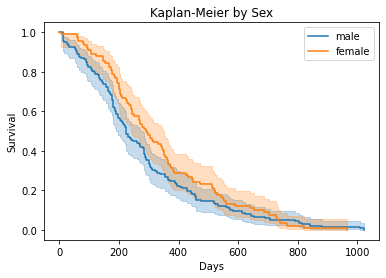

In [30]:
# plot males and females
male_model.plot(label = 'male')
female_model.plot(label = 'female')
plt.title("Kaplan-Meier by Sex")
plt.xlabel("Days")
plt.ylabel("Survival")

# Censoring

* Right Censoring
* Left Censoring
* Interval Censoring

Censoring is a form of missing data problem in which time to event is not observed for reasons such as termination of study before all recruited subjects have shown the event of interest or the subject has left the study prior to experiencing an event. Censoring is common in survival analysis.

Right censoring will occur, for example, for those subjects whose birth date is known but who are still alive when they are lost to follow-up or when the study ends. We generally encounter right-censored data.

If the event of interest has already happened before the subject is included in the study but it is not known when it occurred, the data is said to be left-censored. When it can only be said that the event happened between two observations or examinations, this is interval censoring.

Left censoring occurs for example when a permanent tooth has already emerged prior to the start of a dental study that aims to estimate its emergence distribution. In the same study, an emergence time is interval-censored when the permanent tooth is present in the mouth at the current examination but not yet at the previous examination. 

https://en.wikipedia.org/wiki/Survival_analysis#Censoring

# Log Rank Test

* Compares survival probabilities of two groups
* Null hypothesis: there is no difference
* Hazard Ratio:
* May not be appropriate if survival curves cross

The logrank test, or log-rank test, is a hypothesis test to compare the survival distributions of two samples. It is a nonparametric test and appropriate to use when the data are right skewed and censored (technically, the censoring must be non-informative).

https://en.wikipedia.org/wiki/Logrank_test

The logrank test is used to test the null hypothesis that there is no difference between the populations in the probability of an event (here a death) at any time point. The analysis is based on the times of events (here deaths)... Because the logrank test is purely a test of significance it cannot provide an estimate of the size of the difference between the groups or a confidence interval. For these we must make some assumptions about the data. Common methods use the hazard ratio

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC403858/

In [31]:
# log rank test
from lifelines.statistics import logrank_test

logrank_test(durations_A=m.time,
             durations_B=f.time,
             event_observed_A=m.status,
             event_observed_B=f.status)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.11 0.15      2.77

p is not low supporting the null hypothesis that the two groups are similar

# Cox Hazard Regression

Proportional hazards models are a class of survival models in statistics. Survival models relate the time that passes, before some event occurs, to one or more covariates that may be associated with that quantity of time... There is a relationship between proportional hazards models and Poisson regression models which is sometimes used to fit approximate proportional hazards models in software for Poisson regression. 

https://en.wikipedia.org/wiki/Proportional_hazards_model

* The survival function is a function of time and shows the proportion of subject's status at time t
* Cox Hazard Regression lets us see the impact of all variants on the status
* Adjustments are made based on variance

In [32]:
# engineer the status for better performance /  true false

lung.loc[lung.status == 1, "status"] = 0
lung.loc[lung.status == 2, "status"] = 1
lung.drop('inst', axis=1, inplace=True)

In [33]:
from lifelines import CoxPHFitter

model = CoxPHFitter()
model.fit(lung, 'time', event_col = 'status')
model.print_summary()

<lifelines.CoxPHFitter: fitted with 228 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 228
number of events observed = 165
   partial log-likelihood = -731.39
         time fit was run = 2022-06-23 14:05:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
sex        -0.59       0.56       0.17            -0.92            -0.26                 0.40                 0.77
ph.ecog     0.57       1.77       0.18             0.21             0.93                 1.24                 2.54
ph.karno    0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
pat.karno  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
meal.cal    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
wt.loss    -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  1.30   0.20       2.36
sex           0.00 -3.46 <0.005      10.87
ph.ecog       0.00  3.12 <0.005       9.13
ph.karno      0.00  1.35   0.18       2.49
pat.karno     0.00 -1.75   0.08       3.63
meal.cal      0.00  0.12   0.91       0.14
wt.loss       0.00 -1.72   0.09       3.55
---
Concordance = 0.65
Partial AIC = 1476.79
log-likelihood ratio test = 37.03 on 7 df
-log2(p) of ll-ratio test = 17.72

<AxesSubplot:xlabel='log(HR) (95% CI)'>

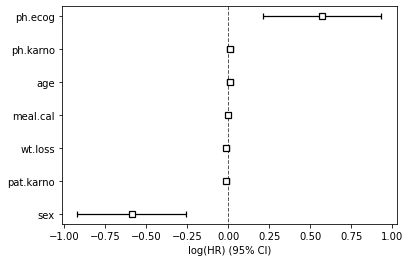

In [34]:
# plot the model
model.plot()

* This plot shows that sex and ph.ecog are significant (p values of .01 and <.005 respectively)
* Logs: how many times to multiply a number to get to another number - https://www.mathsisfun.com/algebra/logarithms.html
* The log of 2^3 is three